In [21]:
import numpy as np
from aspergillus_msb import *
import pickle
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import time
from aspergillus_msb import *
from adaptation_rate_calculation import *
import os
import pandas as pd
from collections import Counter
from scipy.optimize import curve_fit

In [29]:
with open('aspergillus_landscape.txt', 'rb') as f:
    landscape = pickle.load(f)
landscape['00011010'] = 0.0
with open('local_maxima_aspergillus.txt', 'rb') as f:
    local_maxima = pickle.load(f)
file = 'results_aspergillus_msb_2.txt'
with open(file, 'rb') as f:
    results = pickle.load(f)

In [3]:
genotypes = [tuple(x) for x in landscape.keys()]

all_genotypes = []
for i in range(2):
    for g in genotypes:
        all_genotypes.append((i, g))
        
params = {'mu': [1e-7, 1e-6, 1e-5], 'tau': [10, 100]}
params = list(ParameterGrid(params))
initial_genotype = tuple(list(local_maxima.keys())[2])
noise_levels = np.logspace(-6,np.log10(0.5), 30)

In [4]:
population = results[4]['result'][0]['pop']
mu, tau = results[4]['mu'], results[4]['tau']

In [33]:
def calculate_rate_appearance_approximation(noise, mu, tau, s, bridges):
    B = len(bridges)
    
    M1 = calculate_M1(noise, mu*8,tau,s)
    m1 = calculate_m1(noise, mu*8,tau,s)
    
    from_M1 = (B/8)*tau*mu*((1-tau*mu)**5)*M1
    from_m1 = (B/8)*mu*((1-mu)**5)*m1
    
    #return(from_M1+from_m1)
    return(from_M1)

def calculate_rate_appearance(all_genotypes, results, landscape, param, noise):
   
    mu, tau = results[param]['mu'], results[param]['tau']
    population = results[param]['result'][noise]['pop']
    genotypes = [tuple(x) for x in landscape.keys()]
    
    # calculate possible adaptations
    possible_dm = [g for g in genotypes if (hamming(g, list(initial_genotype)) == 2/len(initial_genotype)) and landscape["".join(g)]>landscape["".join(initial_genotype)]]

    # calculate intermediate one mutants between adaptations
    possible_inter = []
    for dm in possible_dm:
        intermediates = [g for g in genotypes if (hamming(g, list(initial_genotype)) == 1/len(initial_genotype)) and (hamming(g, list(dm)) == 1/len(initial_genotype))]
        for i in intermediates:
            for mr in range(2):
                possible_inter.append((mr,i))

    # calculate M1, m1
    rate_appearance = 0
    for inter in possible_inter:
        index = all_genotypes.index(inter)
        if inter[0] == 0:
            rate_appearance += mu * ((1-mu)**(len(inter[1])-1)) * population[index]
        elif inter[0] == 1:
            rate_appearance += tau*mu * ((1-tau*mu)**(len(inter[1])-1)) * population[index]

    # return rate of appearance
    return(rate_appearance)

In [6]:
bridges = ['10000000', '00010000', '10011000', '10000000', '10010001', '10000000', '11010000', '10011000']

In [7]:
selection_coefficients =  0.15060240963855423

In [8]:
M1_2 = [calculate_M1(noise_levels[x], 8*results[2]['mu'], results[2]['tau'],selection_coefficients) for x in range(30)]
M1_3 = [calculate_M1(noise_levels[x], 8*results[3]['mu'], results[3]['tau'],selection_coefficients) for x in range(30)]

m1_2 = [calculate_m1(noise_levels[x], 8*results[2]['mu'], results[2]['tau'],selection_coefficients) for x in range(30)]
m1_3 = [calculate_m1(noise_levels[x], 8*results[3]['mu'], results[3]['tau'],selection_coefficients) for x in range(30)]

In [9]:
approx_2 = 1e5*((np.array(m1_2) * results[2]['mu'] * (1-results[2]['mu'])**7) + (np.array(M1_2) * results[2]['mu']*results[2]['tau'] * (1-results[2]['mu']*results[2]['tau'])**7))

### Comparison with Stochastic Simulations

In [11]:
files = [x for x in os.listdir() if 'results_appearance' in x and '100000.' in x and 'msb_2' in x]

# parsing
param = int(files[0].split('_')[2])
gamma = int(files[0].split('_')[3])
popsize = int(files[0].split('_')[-1].split('.')[0])

all_appearance_results = []
all_results = {}
for file in files:
    with open(file, 'rb') as f:
        result = pickle.load(f)
        
    param = int(file.split('_')[2])
    gamma = int(file.split('_')[3])
    popsize = int(file.split('_')[-1].split('.')[0])
    
    all_results[(param,gamma)] = result['appearances']
    #all_results.append(result['appearances'])
    
    all_appearance_results.append({'param':param, 'gamma':gamma, 'popsize':popsize, 'appearance':np.mean(result['appearances']), 'arraya_appearance':result['appearances']})

all_appearance_results_df = pd.DataFrame(all_appearance_results)

param2_appearance = all_appearance_results_df[all_appearance_results_df['param'] == 2]
param3_appearance = all_appearance_results_df[all_appearance_results_df['param'] == 3]

In [31]:
param = 2
noise = 4

mu, tau = results[param]['mu'], results[param]['tau']
population = results[param]['result'][noise]['pop']
genotypes = [tuple(x) for x in landscape.keys()]

# calculate possible adaptations
possible_dm = [g for g in genotypes if (hamming(g, list(initial_genotype)) == 2/len(initial_genotype)) and landscape["".join(g)]>landscape["".join(initial_genotype)]]

# calculate intermediate one mutants between adaptations
possible_inter = []
for dm in possible_dm:
    intermediates = [g for g in genotypes if (hamming(g, list(initial_genotype)) == 1/len(initial_genotype)) and (hamming(g, list(dm)) == 1/len(initial_genotype))]
    for i in intermediates:
        for mr in range(2):
            possible_inter.append((mr,i))

In [73]:
all_results.keys()

dict_keys([(2, 10), (2, 15), (2, 20), (2, 25), (2, 29), (2, 5)])

In [74]:
short_noise_indexes = [5,10,15,20,25,29]

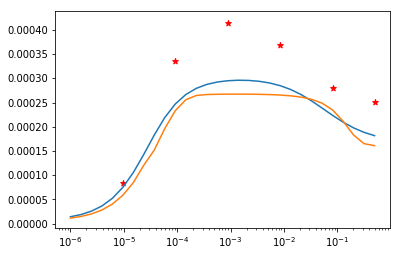

In [85]:
plt.plot(noise_levels, [1e5*calculate_rate_appearance(all_genotypes, results, landscape, 2, noise) for noise in range(30)], linewidth = '1.5')
plt.scatter([noise_levels[x] for x in [5,10,15,20,25,29]], all_estimated_v, c = 'r', marker = '*')
#plt.plot(noise_levels, 8*(4/28)*approx_2)
#plt.errorbar([noise_levels[5], noise_levels[10], noise_levels[15], noise_levels[20], noise_levels[25], noise_levels[29]],  [1/int(param2_appearance['appearance'][param2_appearance['gamma'] == g]) for g in [5,10,15,20,25,29]],new_error_bars, linestyle = '', c = 'k')
plt.plot(noise_levels, approx_2)
plt.xscale('log')

In [87]:
aspergillus_data = {'numerical': [1e5*calculate_rate_appearance(all_genotypes, results, landscape, 2, noise) for noise in range(30)], 'approx': approx_2, 'simulations': all_estimated_v}

In [88]:
with open('aspergillus_appearance_data_geom_sampling.txt', 'wb') as f:
    pickle.dump(aspergillus_data, f)